<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week12-SVM/SVM-Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np


class SVM:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        self.b = 0

    # Hinge Loss Function / Calculation
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0][0]

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=2000):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C

        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.zeros((1, number_of_features))
        b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.hingeloss(w, b, X, Y)

            # Appending all losses 
            losses.append(l)
            
            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                            
                            
                        else:
                            # Calculating the gradients

                            #w.r.t w 
                            gradw += c * -1 * Y[x] * X[x]
                            # w.r.t b
                            gradb += c * -1 * Y[x]

                # Updating weights and bias
                w = w - learning_rate * gradw
                b = b - learning_rate * gradb
        
        self.w = w
        self.b = b

        return self.w, self.b, losses

    def predict(self, X):
        
        prediction = np.dot(X, self.w[0]) + self.b # w.x + b
        return np.sign(prediction)

In [41]:
# prediction.py

from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Creating dataset
X, y = datasets.make_blobs(

        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=40
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [43]:
svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

In [44]:
prediction = svm.predict(X_test)

# Loss value
lss = losses.pop()

print("Loss:", lss)
print("Prediction:", prediction)
print("Accuracy:", accuracy_score(prediction, y_test))
print("w, b:", [w, b])

Loss: 0.10146179096160396
Prediction: [-1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.
  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.]
Accuracy: 1.0
w, b: [array([[0.4504704 , 0.14665864]]), 0.023000000000000007]


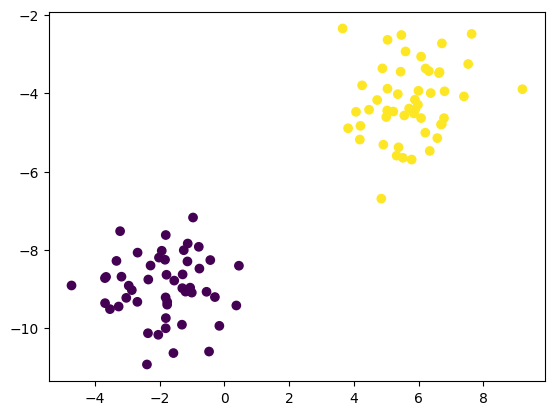

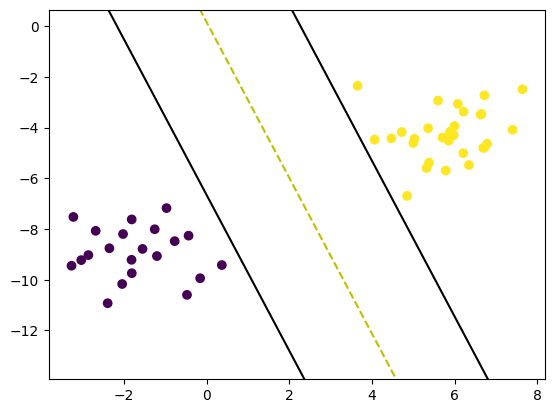

In [45]:
# Visualizing the scatter plot of the dataset
def visualize_dataset():
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm():

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0][0] * x + b + offset) / w[0][1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="o", c=y_test)

    x0_1 = np.amin(X_test[:, 0])
    x0_2 = np.amax(X_test[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset()
visualize_svm()

# Exercise
1. Create a hinge loss function and use it to check when to stop training.
2. Implement Stochastic GD version.